In [ ]:
import os
import sys
import math

import tqdm
import numpy as np
import pandas as pd
import mdtraj as md

from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib import rc

from utils.molden_convert import *

rc('axes', linewidth=1.0)
myfont = 'Arial'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['ps.fonttype'] = 'truetype'
plt.rcParams['font.family'] = myfont
plt.rcParams["font.size"] = 8
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["mathtext.default"] = "regular"

def create_term_labels(n_monomer = 2, n_le = 1):
    terms = []
    for i in range(n_monomer):
        for j in range(n_le):
            terms.append(f"{i+1}e({j+1})")
    for i in range(n_monomer):
        for j in range(i+1, n_monomer):
            terms.append(f"{i+1}+{j+1}-")
            terms.append(f"{i+1}-{j+1}+")
    return terms

def superimpose_matrices(coord1, coord2):
    """
    Compute the optimal rotation matrix and translation vector
    to superimpose two sets of coordinates (coord1 and coord2).
    
    Parameters:
    - coord1: First set of coordinates (natom x 3 numpy array).
    - coord2: Second set of coordinates (natom x 3 numpy array).
    
    Returns:
    - rotation_matrix: The optimal rotation matrix (3x3 numpy array).
    - translation_vector: The translation vector (1x3 numpy array).
    """
    # Ensure the input are numpy arrays and have the correct shape
    assert coord1.shape == coord2.shape, "The shape of the two sets of coordinates must be the same."

    # Calculate the centroids of each set of coordinates
    centroid1 = np.mean(coord1, axis=0)
    centroid2 = np.mean(coord2, axis=0)

    # Center the coordinates at the origin
    coord1_centered = coord1 - centroid1
    coord2_centered = coord2 - centroid2

    # Compute the covariance matrix
    covariance_matrix = np.dot(coord1_centered.T, coord2_centered)

    # Perform Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(covariance_matrix)

    # Compute the optimal rotation matrix
    rotation_matrix = np.dot(Vt.T, U.T)

    # Ensure a right-handed coordinate system
    if np.linalg.det(rotation_matrix) < 0:
        Vt[-1, :] *= -1
        rotation_matrix = np.dot(Vt.T, U.T)

    # Compute the translation vector
    translation_vector = centroid2 - np.dot(rotation_matrix, centroid1)

    return rotation_matrix, translation_vector

def read_xyz(xyzpath:str):
    '''read xyz file and return a list of symbols and a list of coordinates'''
    with open(xyzpath, 'r') as f:
        lines = f.readlines()
    symbols = []
    coords = []
    for line in lines[2:]:
        symbol, *coord = line.split()
        symbols.append(symbol)
        coords.append([float(c) for c in coord])
    return np.array(symbols, dtype = np.dtype("S")), np.array(coords)


monomername = "perylene"
monomernatom = 32

supfolder = "data"
monomerfolder = os.path.join(supfolder, "monomer")
dataset_folder = os.path.join(supfolder, "oos-"+monomername)
dataset_names = ["oPrDim", "oPrTri", "oPrTet"] if monomername == "perylene" else ["oTtDim", "oTtTri", "oTtTet"]

monomerxyzfile = os.path.join(monomerfolder, f"{monomername}.xyz")
monomeroutfile = os.path.join(monomerfolder, f"{monomername}.out")

state_idx = 0
symbols, ref_xyz = read_xyz(monomerxyzfile)
exts = read_cis_output(monomeroutfile)
extm = exts[state_idx]
ref_tdm = np.array([extm.Tx, extm.Ty, extm.Tz])

In [33]:
def split_cfms_to_monomer_pairs(aggxyz:np.ndarray):
    # read xyz structures split them into monomers
    coordinates = []
    n_monomers = []
    for i, xyz in enumerate(aggxyz):
        # split into monomers
        n_monomer = len(xyz) // monomernatom
        n_monomers.append(n_monomer)
        for j in range(n_monomer):
            coordinates.append(xyz[j*monomernatom:(j+1)*monomernatom])

    # convert to numpy array
    coordinates = np.array(coordinates)
    n_monomers = np.array(n_monomers)
    aggregate_idx = np.cumsum(n_monomers)

    # generate monomer pairs
    monomer_pairs = []
    pair_aggregate_idx = []
    lastidx = 0
    for o, i in enumerate(aggregate_idx):
        for j in range(lastidx, i):
            for k in range(j+1, i):
                monomer_pairs.append((j,k))
                pair_aggregate_idx.append(o)
        lastidx = i
    monomer_pairs = np.array(monomer_pairs)
    pair_aggregate_idx = np.array(pair_aggregate_idx)
    return coordinates, aggregate_idx

def get_predicted_energy_coeff(pred_h:pd.DataFrame, targ_h:pd.DataFrame, stateidx = 0):
    # reindex the dataframes by the created term order
    terms = create_term_labels(num_monomer_per_aggregate, 1)
    mindex = pd.MultiIndex.from_product([terms, terms], names = ["term1", "term2"])
    pred_h = pred_h.reindex(mindex)
    targ_h = targ_h.reindex(mindex)

    # reformat the dataframe into matrices
    terms = create_term_labels(num_monomer_per_aggregate, 1)
    le_terms = [t for t in terms if t.find("e") != -1]
    ct_terms = [t for t in terms if t.find("e") == -1]

    # what if some terms is accurate
    replace_vle = False
    replace_tct = False
    replace_ele = False
    replace_ect = False

    if replace_vle:
        for term1 in le_terms:
            for term2 in le_terms:
                if term1 == term2:
                    continue
                pred_h.loc[(term1, term2), :] = targ_h.loc[(term1, term2), :].values
    if replace_tct:
        for term1 in le_terms:
            for term2 in ct_terms:
                pred_h.loc[(term1, term2), :] = targ_h.loc[(term1, term2), :].values
                pred_h.loc[(term2, term1), :] = targ_h.loc[(term2, term1), :].values
    if replace_ele:
        for term in le_terms:
            pred_h.loc[(term, term), :] = targ_h.loc[(term, term), :].values
    if replace_ect:
        for term in ct_terms:
            pred_h.loc[(term, term), :] = targ_h.loc[(term, term), :].values

    term_labels = pred_h.index.values
    term_labels = term_labels.reshape(len(terms), len(terms))

    pred_h_ = pred_h.values.copy()
    targ_h_ = targ_h.values.copy()    # (N, 81)
    pred_h_ = pred_h_.transpose(1, 0).reshape(-1, len(terms), len(terms))   # (N, 9, 9)
    targ_h_ = targ_h_.transpose(1, 0).reshape(-1, len(terms), len(terms))   # (N, 9, 9)

    pred_es, pred_Cs = np.linalg.eigh(pred_h_)
    targ_es, targ_Cs = np.linalg.eigh(targ_h_)
    targ_es = targ_es[:,stateidx]
    pred_es = pred_es[:,stateidx]
    # accu_es = data_d.loc[("ad(1)", "e"), :].values * 27.2114 * 1000

    return pred_es, pred_Cs

def estimate_oscillator_strength(aggxyzs:np.ndarray, ref_xyz:np.ndarray, ref_tdm:np.ndarray, pred_es:np.ndarray, pred_Cs:np.ndarray, stateidx = 0):
    
    coordinates, aggregate_idx = split_cfms_to_monomer_pairs(aggxyzs)
    n_aggregate = len(aggregate_idx)

    # compute the transformation matrix from the monomer reference xyz to 
    cords = np.array(coordinates)
    dspls = np.empty([coordinates.shape[0], 3])
    rotms = np.empty([coordinates.shape[0], 3, 3])

    for i in range(coordinates.shape[0]):
        rotm, dspl = superimpose_matrices(ref_xyz, cords[i])
        dspls[i] = dspl
        rotms[i] = rotm

    # obtain the transition dipole moment for the monomer
    mtdm = ref_tdm
    mtdms = mtdm @ rotms.transpose(0, 2, 1)
    aggregate_s1tdms = np.zeros((n_aggregate, 3))
    # bggregate_s1tdms = np.zeros((n_aggregate, 3))
    # target_mtdms = np.zeros((n_aggregate*num_monomer_per_aggregate, 3))
    lastidx = 0
    for i, agidx in enumerate(aggregate_idx):
        for j in range(0, agidx - lastidx):
            aggregate_s1tdms[i] += mtdms[j+lastidx] * pred_Cs[i,j,stateidx]
            # target_mtdms[lastidx+j] = np.array([data_d.loc[(f"{j+1}e(1)", "Tx")].values[i], data_d.loc[(f"{j+1}e(1)", "Ty")].values[i], data_d.loc[(f"{j+1}e(1)", "Tz")].values[i]])
        lastidx = agidx
    aggregate_s1foscs = np.sum(aggregate_s1tdms**2, axis = -1) * 2 / 3 * pred_es / 27.2114 / 1000
    return aggregate_s1foscs

def plot_kde_with_edge_distribution(fig:plt.Figure, gridcell, xs:np.ndarray, ys:np.ndarray, xmin = 0.0, xmax = 0.8, title = ""):
    zs = gaussian_kde(np.vstack([xs, ys]))(np.vstack([xs, ys]))
    idx = zs.argsort()
    xs, ys, zs = xs[idx], ys[idx], zs[idx]
    R2 = np.corrcoef(xs, ys)[0,1]

    grid = gridcell.subgridspec(4, 4, hspace = 0.0, wspace = 0.0)
    ax_main = fig.add_subplot(grid[1:, :-1])
    ax_xDist = fig.add_subplot(grid[0, :-1], sharex = ax_main)
    ax_yDist = fig.add_subplot(grid[1:, -1], sharey = ax_main)
    ax_main.scatter(xs, ys, 
                    marker = "o", 
                    s = 5, 
                    c = zs,
                    alpha = 1.0,
                    linewidths = 0.5,
                    edgecolors = "none",
                    cmap = "jet")
    ax_main.plot([xmin, xmax], [xmin, xmax], color = "black", linestyle = "--", linewidth = 1.0)
    ax_main.axis([xmin, xmax, xmin, xmax])
    ax_main.tick_params(axis = "both", direction = "in", length = 2, width = 1.0, bottom = True, top = True, left = True, right = True)
    ax_main.text(0.05, 0.95, f"$R^2$={R2:.2f}", transform = ax_main.transAxes, ha = "left", va = "top", 
                 bbox=dict(boxstyle="square",
                   ec=(1., 1., 1.),
                   fc=(1., 1., 1.),
                   ))


    ax_main.set_xlabel("Target", labelpad = 1.0)
    ax_main.set_ylabel("Predicted", labelpad = 1.0)

    nbins = 20
    bins = np.linspace(xmin, xmax, nbins + 1, endpoint = True)
    ax_xDist.hist(xs, bins = bins, orientation = "vertical", color = "royalblue", edgecolor = "black", linewidth = 0.25)
    ax_xDist.tick_params(axis = "both", direction = "in", length = 2, width = 1.0, labelbottom = False)
    ax_xDist.set_xticks(np.linspace(xmin, xmax, 5))
    ax_xDist.set_yticks([0, 50, 100])
    ax_xDist.set_yticklabels(["", "50", "100"])
    ax_xDist.axis([xmin, xmax, 0, 100])
    ax_xDist.set_ylabel("Counts", labelpad = 1.0)
    ax_xDist.tick_params(axis = "both", direction = "in", length = 2, width = 1.0, bottom = True, top = True, left = True, right = True)
    ax_xDist.text(0.95, 0.90, title, transform = ax_xDist.transAxes, ha = "right", va = "top")

    ax_yDist.hist(ys, bins = bins, orientation = "horizontal", color = "royalblue", edgecolor = "black", linewidth = 0.25)
    ax_yDist.tick_params(axis = "both", direction = "in", length = 2, width = 1.0, labelleft = False)
    ax_yDist.set_yticks(np.linspace(xmin, xmax, 5))
    ax_yDist.set_xticks([0, 50, 100])
    ax_yDist.set_xticklabels(["", "50", "100"])
    ax_yDist.axis([0, 100, xmin, xmax])
    ax_yDist.set_xlabel("Counts", labelpad = 1.0)
    ax_yDist.tick_params(axis = "both", direction = "in", length = 2, width = 1.0, bottom = True, top = True, left = True, right = True)


100%|██████████| 3/3 [00:00<00:00,  5.86it/s]


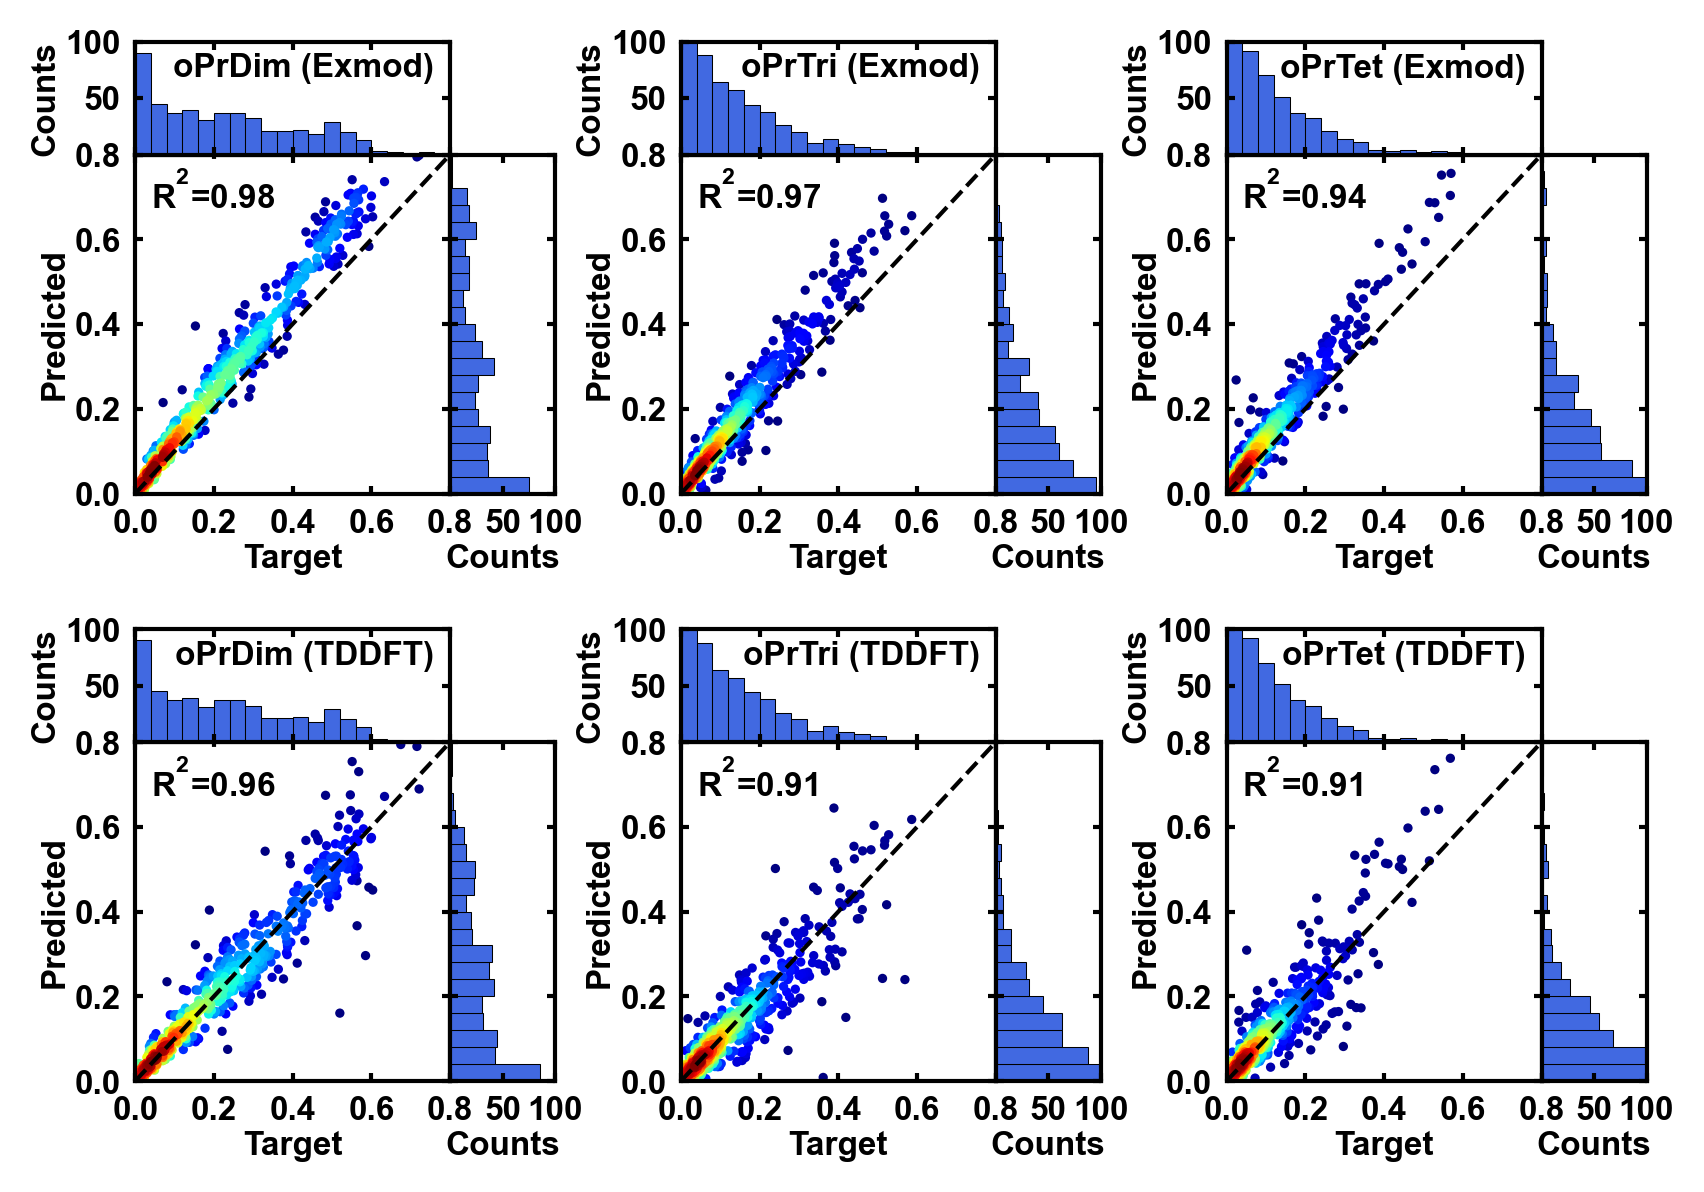

In [34]:


fig = plt.figure(figsize = (6.5, 4.5), dpi = 300)
grid = fig.add_gridspec(2, 3, wspace = 0.3, hspace = 0.3)
xmin, xmax = 0.0, 0.8

for i in tqdm.tqdm(range(3)):
    num_monomer_per_aggregate = i + 2
    dataset_name = dataset_names[i]

    cfms = md.load_hdf5(os.path.join(dataset_folder, f"{dataset_name}.h5"))
    data_d = pd.read_csv(os.path.join(dataset_folder, f"{dataset_name}-d.csv"), index_col = [0,1])
    data_e = pd.read_csv(os.path.join(dataset_folder, f"{dataset_name}-e.csv"), index_col = [0,1])
    pred_h = pd.read_csv(os.path.join(dataset_folder, f"{dataset_name}-pred-h.csv"), index_col = [0,1])
    targ_h = pd.read_csv(os.path.join(dataset_folder, f"{dataset_name}-targ-h.csv"), index_col = [0,1])

    pred_es, pred_Cs = get_predicted_energy_coeff(pred_h, targ_h, stateidx = state_idx)
    pred_fs = estimate_oscillator_strength(cfms.xyz, ref_xyz, ref_tdm, pred_es, pred_Cs, stateidx = state_idx)

    exmd_fs = data_d.loc[(f"ad({state_idx + 1})", "f")]
    tdft_fs = data_e.loc[(state_idx+1, "f")]

    plot_kde_with_edge_distribution(fig, grid[0,i], pred_fs, exmd_fs.values, xmin = xmin, xmax = xmax, title = f"{dataset_name} (Exmod)")
    plot_kde_with_edge_distribution(fig, grid[1,i], pred_fs, tdft_fs.values, xmin = xmin, xmax = xmax, title = f"{dataset_name} (TDDFT)")
    # grid[0,i].set_title(f"{dataset_name} (Exmod)")
    # grid[1,i].set_title(f"{dataset_name} (TDDFT)")
    # AttributeError: 'SubplotSpec' object has no attribute 'set_title'
    # get the axis object and set the title
    # fig.add_subplot(grid[0,i]).set_title(f"{dataset_name} (Exmod)")

